In [1]:
from riskyneuroarousal.modeling.FIRDeconvolution import FIRDeconvolution
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/src/riskyneuroarousal/modeling/FIRDeconvolution.py:225: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if method is 'lstsq':
/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/src/riskyneuroarousal/modeling/FIRDeconvolution.py:228: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  elif method is 'sm_ols':


In [2]:
pth = "/Users/gustxsr/Documents/Stanford/PoldrackLab/PAPERS/paper1_loss_aversion_pupil/eye_data/NARPS_MG_asc_processed"
timeseries = ["sub-003_run-1_timeseries_start2.csv", 
              "sub-003_run-2_timeseries_start2.csv",
              "sub-003_run-3_timeseries_start2.csv",
              "sub-003_run-4_timeseries_start2.csv"]

In [3]:
blink_events = ["sub-003_run-1_blinks.csv",
                "sub-003_run-2_blinks.csv",
                "sub-003_run-3_blinks.csv",
                "sub-003_run-4_blinks.csv"]

saccade_events = ["sub-003_run-1_saccades.csv",
                  "sub-003_run-2_saccades.csv",
                  "sub-003_run-3_saccades.csv",
                  "sub-003_run-4_saccades.csv"]

start_events = ["sub-003_run-1_trial_starts.csv",
                "sub-003_run-2_trial_starts.csv",
                "sub-003_run-3_trial_starts.csv",
                "sub-003_run-4_trial_starts.csv"]

response_events = ["sub-003_run-1_responses.csv",
                   "sub-003_run-2_responses.csv",
                   "sub-003_run-3_responses.csv",
                   "sub-003_run-4_responses.csv"]

duration_events = ["sub-003_run-1_trial_durations.csv",
                    "sub-003_run-2_trial_durations.csv",
                     "sub-003_run-3_trial_durations.csv",
                     "sub-003_run-4_trial_durations.csv"]

In [125]:
signal_sample_frequency = 50
deconv_sample_frequency = 20
deconvolution_interval = [-0.5, 4]

In [126]:
input_signal = []
start_run = []
for i in range(len(timeseries)):
    # Read in the timeseries data
    data = pd.read_csv(f"{pth}/{timeseries[i]}")
    datapoints = data["pupil_raw_deblink_detransient_interpolate_lpfilt_z"].values
    # Pad start and end of datapoints with 5 seconds of 0
    pad = 5
    pad_samples = int(pad * signal_sample_frequency)
    datapoints = np.concatenate((np.zeros(pad_samples), datapoints, np.zeros(pad_samples)))
    input_signal.append(datapoints)
    start_time = data["time_orig"].values[0]
    start_run.append(start_time)

In [ ]:
# input_signal = input_signal[0][0:1]
# start_run = start_run[0:1]

IndexError: invalid index to scalar variable.

In [127]:
def get_event_times(event_file, input_signal, signal_sample_frequency, start_run, time_name = 'end'):
    event_times = []
    for i in range(len(event_file)):
        # Events
        event = pd.read_csv(f"{pth}/{event_file[i]}")
        event["time_true"] = (event[time_name] - start_run[i])/1000 + 5
        if i > 0:
            for j in range(0, i):
                event["time_true"] += len(input_signal[j])/signal_sample_frequency + 5
        event_times.append(event["time_true"].values)
    return np.concatenate(event_times)

In [128]:
blink_times = get_event_times(blink_events, input_signal, signal_sample_frequency, start_run, time_name = "x")
saccade_times = get_event_times(saccade_events, input_signal, signal_sample_frequency, start_run, time_name = "x")
start_times = get_event_times(start_events, input_signal, signal_sample_frequency, start_run, time_name = "start_time")
response_times = get_event_times(response_events, input_signal, signal_sample_frequency, start_run, time_name = "response_time")
duration_times = get_event_times(duration_events, input_signal, signal_sample_frequency, start_run, time_name = "start_time")

In [129]:
decision_durations = []
for i in range(len(duration_events)):
    # Read in the timeseries data
    data = pd.read_csv(f"{pth}/{duration_events[i]}")
    decision_durations.append(data["duration"].values/1000)
decision_durations = decision_durations
decision_durations = np.concatenate(decision_durations)

In [130]:
durations = {'decision': decision_durations, 
            'response': np.array([0.001] * len(response_times)),
            'start': np.array([0.001] * len(start_times)),
            'blink': np.array([0.001] * len(blink_times)),
            'saccade': np.array([0.001] * len(saccade_times))}

In [131]:
fd = FIRDeconvolution(
            signal = datapoints, 
            events = [blink_times, saccade_times], 
            event_names = ['blink', 'saccade'],
            # durations = durations, 
            sample_frequency = signal_sample_frequency,
            deconvolution_frequency = deconv_sample_frequency,
            deconvolution_interval = deconvolution_interval
            )

# we then tell it to create its design matrix
fd.create_design_matrix()

# perform the actual regression, in this case with the statsmodels backend
# fd.ridge_regress(cv = 10, alphas = np.logspace(-5, 3, 15))
fd.regress(method = 'lstsq')

# and partition the resulting betas according to the different event types
fd.betas_for_events()

fd.calculate_rsq()

# and we see what we've done

array(0.06766863)

/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_89581/3787226443.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s.set_title('FIR responses, Rsq is %1.3f'%fd.rsq)


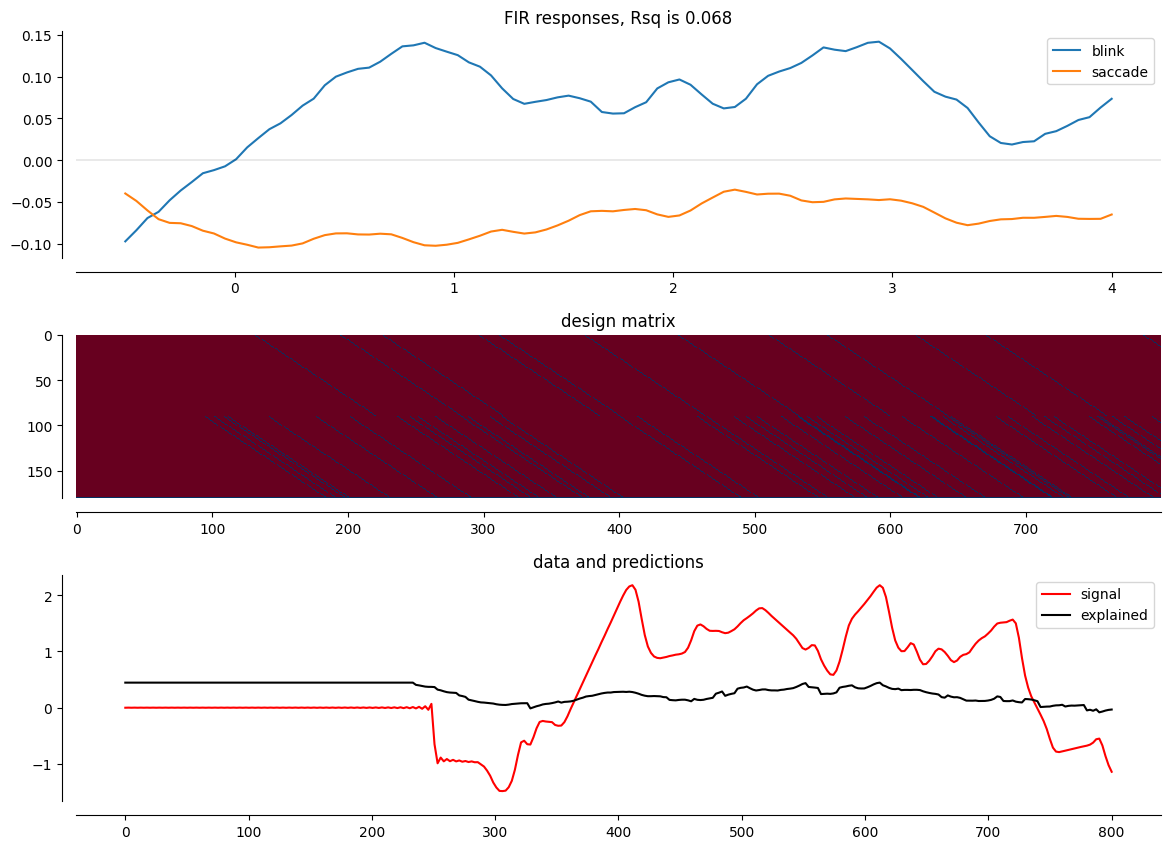

In [132]:
figwidth, figheight = 14, 10
plot_time = 800

f = plt.figure(figsize = (figwidth, figheight))
s = f.add_subplot(311)
s.set_title('FIR responses, Rsq is %1.3f'%fd.rsq)
for dec in fd.betas_per_event_type.squeeze():
    plt.plot(fd.deconvolution_interval_timepoints, dec)
# fd.covariates, being a dictionary, cannot be assumed to maintain the event order. 
# working on a fix here....
plt.legend(fd.covariates.keys())
sns.despine(offset=10)

plt.axhline(0, lw=0.25, alpha=0.5, color = 'k')
s = f.add_subplot(312)
s.set_title('design matrix')
plt.imshow(fd.design_matrix[:,:plot_time], aspect = 0.075 * plot_time/fd.deconvolution_interval_size, cmap = 'RdBu', interpolation = 'nearest', rasterized = True)
sns.despine(offset=10)

s = f.add_subplot(313)
s.set_title('data and predictions')
plt.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
        fd.resampled_signal[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)].T, 'r')
plt.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
        fd.predict_from_design_matrix(fd.design_matrix[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)]).T, 'k')
plt.legend(['signal','explained'])
sns.despine(offset=10)